In [40]:
import random
import numpy as np
import math

# Task 1

In [41]:
class Individual:
    def __init__(self, n, bit_values):
        self.n = n
        self.bit_values = bit_values
    
    def mutate(self):
        mutated_bit_values = self.bit_values.copy()
        k = np.random.binomial(self.n, 1/self.n)
        indices = random.sample(range(self.n), k)
        for i in indices:
            mutated_bit_values[i] = 1 - mutated_bit_values[i]
        return Individual(self.n, mutated_bit_values)
    
    
# def flip_bits_randomly(bits, p):   (geometric distribution version)
#     n = len(bits)
#     i = 0
#     while i < n:
#         # geometric distribution: number of trials until success
#         # geometric(p) can be sampled via inverse CDF
#         skip = int(math.log(1 - random.random()) / math.log(1 - p))

#         i += skip
#         if i >= n:
#             break

#         bits[i] ^= 1   # flip the bit
#         i += 1

In [42]:
class Frequency_Vector :
    def __init__(self, n, values=None): 
        self.n = n
        if values is None:
            self.values = [1/n]*n
        else :
            self.values = []
            for v in values:
                v = max(min(v,1-1/n),1/n)
                self.values.append(v)

    
    def update(self, i, p_i):
        self.values[i] = max(min(p_i,1-1/self.n),1/self.n)
        
    # def get(self, i):
    #     return self.values[i]
    
    def generate_individual(self):
        bit_values = []
        for i in range(self.n):
            r = random.random()
            if r < self.values[i]:
                bit_values.append(1)
            else:
                bit_values.append(0)
        return Individual(self.n, bit_values)
    
    

# Task 2

In [43]:
def sig(p, H, eps, n):
    m = H[0]
    limit = m*p+eps*max(np.sqrt(m*p*np.log(n)), np.log(n))
    if limit <= H[1] and p in [1/n,1/2]:
        return 1 # UP
    elif limit <= H[0] - H[1] and p in [1-1/n,1/2]:
        return -1 # DOWN
    else:
        return 0 # STAY
    

In [44]:
class Simplified_History :
    def __init__(self, size=0, zeros=0, ones=0):
        self.size = size
        self.zeros = zeros
        self.ones = ones
    
    def add(self, ind, n):
        self.size+=1
        if ind == 1:
            self.ones+=1
        else:
            self.zeros+=1    
    
    def count_ones(self):
        return self.ones
    
    def count_zeros(self):
        return self.zeros
    
    def get_subsequences(self):
        return [[self.size, self.ones]]
    
    def reset(self):
        self.size = 0
        self.zeros = 0
        self.ones = 0

In [45]:
class Original_History :
    def __init__(self, size=0, ones=0, next=None):
        self.size = size
        self.ones = ones
        self.next = next

    def count_ones(self):
        return self.ones

    def count_zeros(self):
        return self.size - self.ones

    def add(self, ind, n):
        block_limit = max(1, int(math.log(n)))

        if self.size < block_limit:
            self.size += 1
            if ind == 1:
                self.ones += 1
            return

        # Insert a new head block in-place so references in H[] stay valid.
        old_head = Original_History(self.size, self.ones, self.next)
        self.size = 1
        self.ones = 1 if ind == 1 else 0
        self.next = old_head
        consolidate(self)

    def get_subsequences(self):
        subsequences = []
        curr = self
        while curr is not None:
            if curr.size > 0:
                if subsequences:
                    subsequences.append([
                        curr.size + subsequences[-1][0],
                        curr.ones + subsequences[-1][1],
                    ])
                else:
                    subsequences.append([curr.size, curr.ones])
            curr = curr.next
        return subsequences

    def reset(self):
        self.size = 0
        self.ones = 0
        self.next = None


def consolidate(L):
    curr = L
    if curr is not None:
        next = curr.next
        alreadySeenDouble = False
        while next is not None:
            if curr.size == next.size:
                if alreadySeenDouble:
                    curr.size += next.size
                    curr.ones += next.ones
                    curr.next = next.next
                    next = curr.next
                    alreadySeenDouble = False
                else:
                    alreadySeenDouble = True
                    curr = next
                    next = curr.next
            else:
                curr = next
                next = curr.next



The maximum number of merges is $O(log(m))$ where $m$ is the number of bits added so far, this happens when each block size doubles, for example: 

# Task 3

In [46]:
def sig_cga(f, termination_condition, n, history_type, eps):
    t = 0
    x_1 = None # have to initialize x_1 for the termination condition
    p = Frequency_Vector(n, [0.5]*n)
    if history_type == "simplified":
        H = [Simplified_History() for _ in range(n+1)]
    else:
        H = [Original_History() for _ in range(n+1)]
    while not termination_condition(t, x_1):  # have to depend on an individual ?
        x_1 = p.generate_individual()
        x_2 = p.generate_individual()
        if f(x_1) < f(x_2):
            x_1, x_2 = x_2, x_1
        for i in range(n):
            H[i].add(x_1.bit_values[i], n)
            for h in H[i].get_subsequences():
                s = sig(p.values[i], h, eps, n)
                if s == 1:
                    p.update(i, 1-1/n)
                elif s == -1:
                    p.update(i, 1/n)
                if s != 0:
                    H[i].reset()
                    break
        t+=1
    return x_1,t

# Task 4

In [47]:
def cga(K, n, f, termination_criterion):
    t = 0
    x_1 = None
    p = Frequency_Vector(n, [0.5]*n)
    while not termination_criterion(t, x_1):
        x_1 = p.generate_individual()
        x_2 = p.generate_individual()
        if f(x_1) < f(x_2):
            x_1, x_2 = x_2, x_1
        for i in range(n):
            p.update(i, p.values[i] + 1/K * (x_1.bit_values[i] - x_2.bit_values[i]))
        t+=1
    return x_1,t

def one_plus_one_ea(f, termination_criterion, n):
    t = 0
    x = Individual(n, [random.randint(0, 1) for _ in range(n)])
    while not termination_criterion(t, x):
        y = x.mutate()
        if f(y) > f(x):
            x = y
        t+=1
    return x,t

# Task 5

In [48]:
def OneMax(ind):
    return sum(ind.bit_values)

def LeadingOnes(ind):
    count = 0
    for bit in ind.bit_values:
        if bit == 1:
            count += 1
        else:
            break
    return count

def Jump(ind, k):
    n = ind.n
    ones = sum(ind.bit_values)
    if ones == n or ones <= n-k:
        return k + ones
    else:
        return n - ones

eval = 1000

def termination_criterion(t, x):
    if x is None:
        return False
    return t >= eval or x.bit_values == [1]*x.n

# Task 6

In [49]:
n_tries = 20

## One Max

In [ ]:
np.random.seed(42)

# fixing parameters for experiments
n_s = [100, 200]
eps_s = [12, 9]   # for sig_cga
def K_s(n):
    K_0 = np.sqrt(n * np.log(n))
    return [0.5*K_0, K_0]
T = 10000

# sig_cga for simplified history results
results_sig_cga_simplified_One_Max = {}
results_sig_cga_original_One_Max = {}
results_cga_One_Max = {}
results_one_plus_one_ea_One_Max = {}
hist_runs_OneMax = []

for n in n_s:
    for eps in eps_s:
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = sig_cga(OneMax, termination_criterion, n, "simplified", eps)
            fit = OneMax(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_OneMax.append({
                "Algorithm": "SigCGA (Simplified)", "Function": "OneMax", "n": n,
                "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_sig_cga_simplified_One_Max[(n, eps)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    for eps in eps_s:
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = sig_cga(OneMax, termination_criterion, n, "original", eps)
            fit = OneMax(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_OneMax.append({
                "Algorithm": "SigCGA (Original)", "Function": "OneMax", "n": n,
                "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_sig_cga_original_One_Max[(n, eps)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    for K in K_s(n):
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = cga(K, n, OneMax, termination_criterion)
            fit = OneMax(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_OneMax.append({
                "Algorithm": "Standard CGA", "Function": "OneMax", "n": n,
                "Parameter Type": "K", "Parameter Value": round(K, 2), "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_cga_One_Max[(n, K)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    f_values = []
    success_count = 0
    t_s = []
    eval = T
    for _ in range(n_tries):
        x, t = one_plus_one_ea(OneMax, termination_criterion, n)
        fit = OneMax(x)
        success = x.bit_values == [1] * n
        f_values.append(fit)
        if success:
            success_count += 1
            t_s.append(t)
        hist_runs_OneMax.append({
            "Algorithm": "1+1 EA", "Function": "OneMax", "n": n,
            "Parameter Type": "N/A", "Parameter Value": "N/A", "Jump k": np.nan,
            "Fitness": fit, "Runtime": t, "Success": int(success)
        })
    results_one_plus_one_ea_One_Max[n] = (
        success_count / n_tries,
        np.mean(t_s) if success_count > 0 else None,
        np.mean(f_values),
        np.std(f_values)
    )


## Leading Ones

In [ ]:
np.random.seed(42)

n_s = [100, 200]
eps_s = [12, 9]
def K_s(n):
    K_0 = n * np.log(n)**2
    return [0.5*K_0, K_0]
T = 10000

results_sig_cga_simplified_LeadingOnes = {}
results_sig_cga_original_LeadingOnes = {}
results_cga_LeadingOnes = {}
results_one_plus_one_ea_LeadingOnes = {}
hist_runs_LeadingOnes = []

for n in n_s:
    for eps in eps_s:
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = sig_cga(LeadingOnes, termination_criterion, n, "simplified", eps)
            fit = LeadingOnes(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_LeadingOnes.append({
                "Algorithm": "SigCGA (Simplified)", "Function": "LeadingOnes", "n": n,
                "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_sig_cga_simplified_LeadingOnes[(n, eps)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    for eps in eps_s:
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = sig_cga(LeadingOnes, termination_criterion, n, "original", eps)
            fit = LeadingOnes(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_LeadingOnes.append({
                "Algorithm": "SigCGA (Original)", "Function": "LeadingOnes", "n": n,
                "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_sig_cga_original_LeadingOnes[(n, eps)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    for K in K_s(n):
        f_values = []
        success_count = 0
        t_s = []
        eval = T // 2
        for _ in range(n_tries):
            x, t = cga(K, n, LeadingOnes, termination_criterion)
            fit = LeadingOnes(x)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_LeadingOnes.append({
                "Algorithm": "Standard CGA", "Function": "LeadingOnes", "n": n,
                "Parameter Type": "K", "Parameter Value": round(K, 2), "Jump k": np.nan,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_cga_LeadingOnes[(n, K)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )

for n in n_s:
    f_values = []
    success_count = 0
    t_s = []
    eval = T
    for _ in range(n_tries):
        x, t = one_plus_one_ea(LeadingOnes, termination_criterion, n)
        fit = LeadingOnes(x)
        success = x.bit_values == [1] * n
        f_values.append(fit)
        if success:
            success_count += 1
            t_s.append(t)
        hist_runs_LeadingOnes.append({
            "Algorithm": "1+1 EA", "Function": "LeadingOnes", "n": n,
            "Parameter Type": "N/A", "Parameter Value": "N/A", "Jump k": np.nan,
            "Fitness": fit, "Runtime": t, "Success": int(success)
        })
    results_one_plus_one_ea_LeadingOnes[n] = (
        success_count / n_tries,
        np.mean(t_s) if success_count > 0 else None,
        np.mean(f_values),
        np.std(f_values)
    )


## Jumping Ones

In [ ]:
np.random.seed(42)

k_s = [2, 3]
n_s = [100, 200]
eps_s = [12, 9]
def K_s(n):
    K_0 = np.sqrt(n * np.log(n))
    return [0.5*K_0, K_0]
T = 10000

results_sig_cga_simplified_Jump = {}
results_sig_cga_original_Jump = {}
results_cga_Jump = {}
results_one_plus_one_ea_Jump = {}
hist_runs_Jump = []

for n in n_s:
    for eps in eps_s:
        for k in k_s:
            f_values = []
            success_count = 0
            t_s = []
            eval = T // 2
            for _ in range(n_tries):
                x, t = sig_cga(lambda x: Jump(x, k), termination_criterion, n, "simplified", eps)
                fit = Jump(x, k)
                success = x.bit_values == [1] * n
                f_values.append(fit)
                if success:
                    success_count += 1
                    t_s.append(t)
                hist_runs_Jump.append({
                    "Algorithm": "SigCGA (Simplified)", "Function": "Jump", "n": n,
                    "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": k,
                    "Fitness": fit, "Runtime": t, "Success": int(success)
                })
            results_sig_cga_simplified_Jump[(n, eps, k)] = (
                success_count / n_tries,
                np.mean(t_s) if success_count > 0 else None,
                np.mean(f_values),
                np.std(f_values)
            )

for n in n_s:
    for eps in eps_s:
        for k in k_s:
            f_values = []
            success_count = 0
            t_s = []
            eval = T // 2
            for _ in range(n_tries):
                x, t = sig_cga(lambda x: Jump(x, k), termination_criterion, n, "original", eps)
                fit = Jump(x, k)
                success = x.bit_values == [1] * n
                f_values.append(fit)
                if success:
                    success_count += 1
                    t_s.append(t)
                hist_runs_Jump.append({
                    "Algorithm": "SigCGA (Original)", "Function": "Jump", "n": n,
                    "Parameter Type": "epsilon", "Parameter Value": eps, "Jump k": k,
                    "Fitness": fit, "Runtime": t, "Success": int(success)
                })
            results_sig_cga_original_Jump[(n, eps, k)] = (
                success_count / n_tries,
                np.mean(t_s) if success_count > 0 else None,
                np.mean(f_values),
                np.std(f_values)
            )

for n in n_s:
    for K in K_s(n):
        for k in k_s:
            f_values = []
            success_count = 0
            t_s = []
            eval = T // 2
            for _ in range(n_tries):
                x, t = cga(K, n, lambda x: Jump(x, k), termination_criterion)
                fit = Jump(x, k)
                success = x.bit_values == [1] * n
                f_values.append(fit)
                if success:
                    success_count += 1
                    t_s.append(t)
                hist_runs_Jump.append({
                    "Algorithm": "Standard CGA", "Function": "Jump", "n": n,
                    "Parameter Type": "K", "Parameter Value": round(K, 2), "Jump k": k,
                    "Fitness": fit, "Runtime": t, "Success": int(success)
                })
            results_cga_Jump[(n, K, k)] = (
                success_count / n_tries,
                np.mean(t_s) if success_count > 0 else None,
                np.mean(f_values),
                np.std(f_values)
            )

for n in n_s:
    for k in k_s:
        f_values = []
        success_count = 0
        t_s = []
        eval = T
        for _ in range(n_tries):
            x, t = one_plus_one_ea(lambda x: Jump(x, k), termination_criterion, n)
            fit = Jump(x, k)
            success = x.bit_values == [1] * n
            f_values.append(fit)
            if success:
                success_count += 1
                t_s.append(t)
            hist_runs_Jump.append({
                "Algorithm": "1+1 EA", "Function": "Jump", "n": n,
                "Parameter Type": "N/A", "Parameter Value": "N/A", "Jump k": k,
                "Fitness": fit, "Runtime": t, "Success": int(success)
            })
        results_one_plus_one_ea_Jump[(n, k)] = (
            success_count / n_tries,
            np.mean(t_s) if success_count > 0 else None,
            np.mean(f_values),
            np.std(f_values)
        )


## Results

### Complete Experiment Summary

Function,Algorithm,n,Parameter Type,Parameter Value,Jump k,Success Rate,Mean Runtime,Mean Fitness
Jump,1+1 EA,100,N/A,N/A,2,20.0%,2236.5,100.40
Jump,1+1 EA,100,N/A,N/A,3,0.0%,nan,100.00
Jump,1+1 EA,300,N/A,N/A,2,0.0%,nan,299.20
Jump,1+1 EA,300,N/A,N/A,3,0.0%,nan,299.70
Jump,SigCGA (Original),100,epsilon,9,2,0.0%,nan,55.60
Jump,SigCGA (Original),100,epsilon,9,3,0.0%,nan,55.30
Jump,SigCGA (Original),100,epsilon,12,2,0.0%,nan,54.10
Jump,SigCGA (Original),100,epsilon,12,3,0.0%,nan,57.90
Jump,SigCGA (Original),300,epsilon,9,2,0.0%,nan,157.90
Jump,SigCGA (Original),300,epsilon,9,3,0.0%,nan,157.10


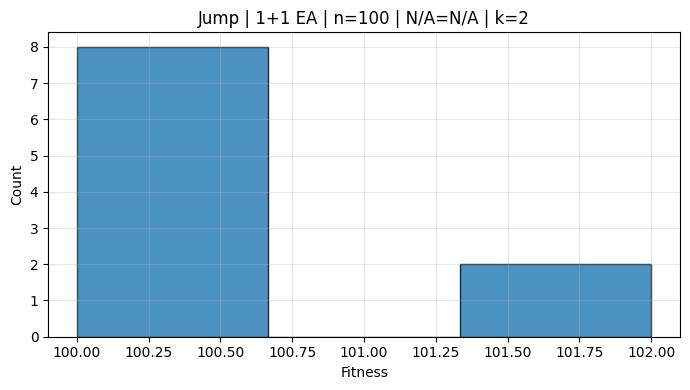

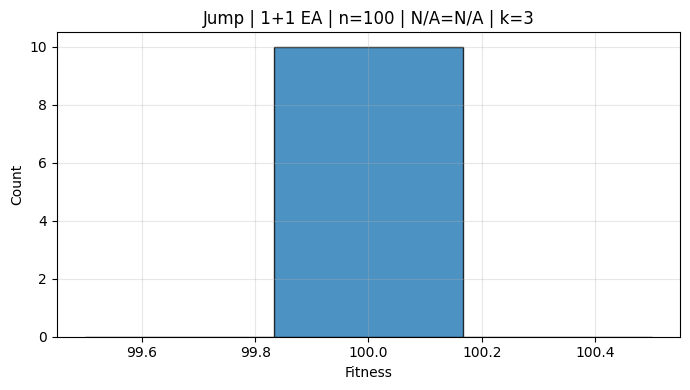

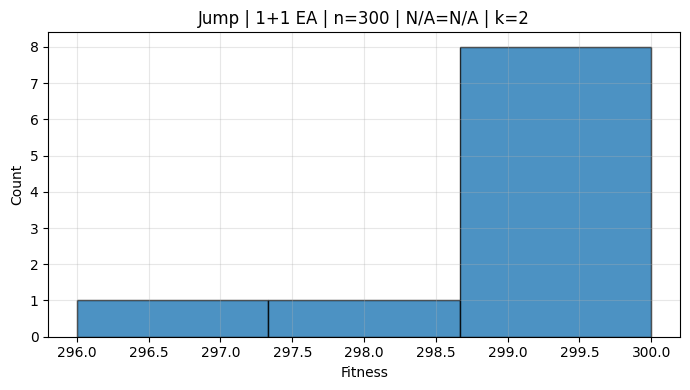

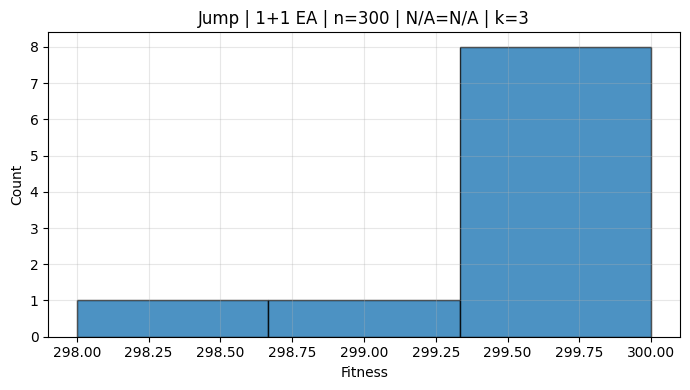

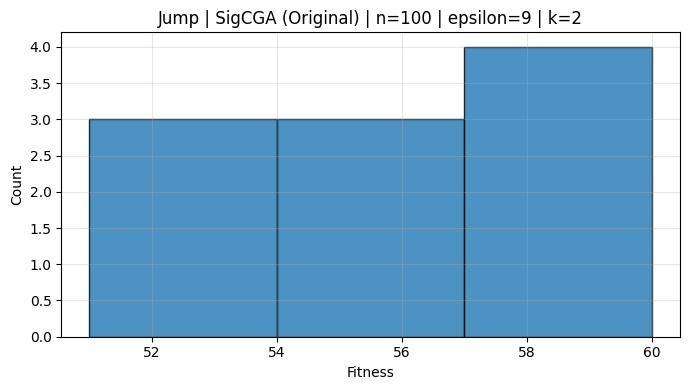

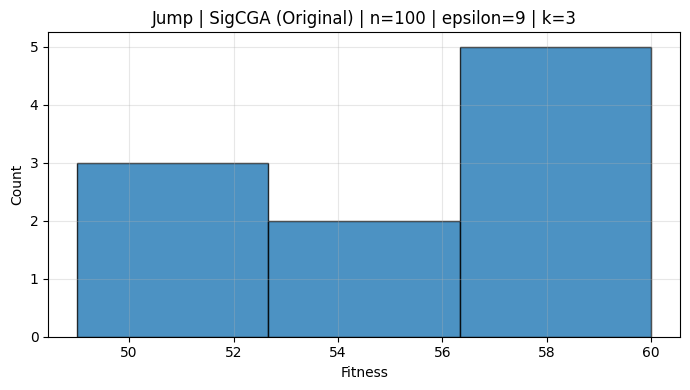

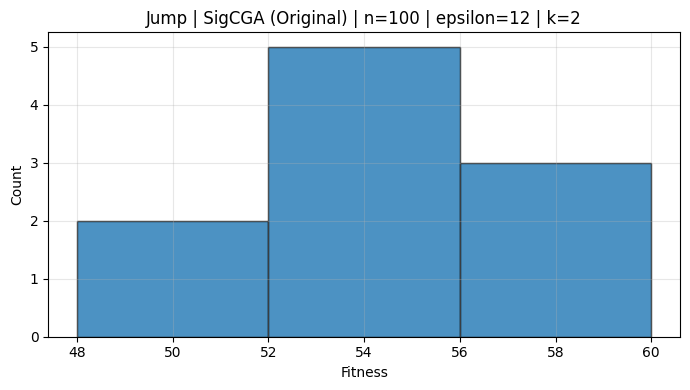

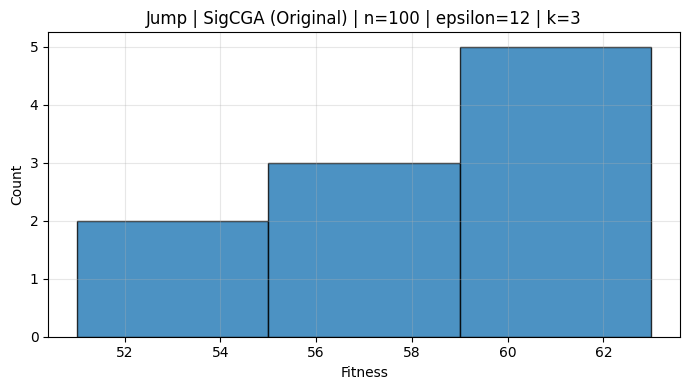

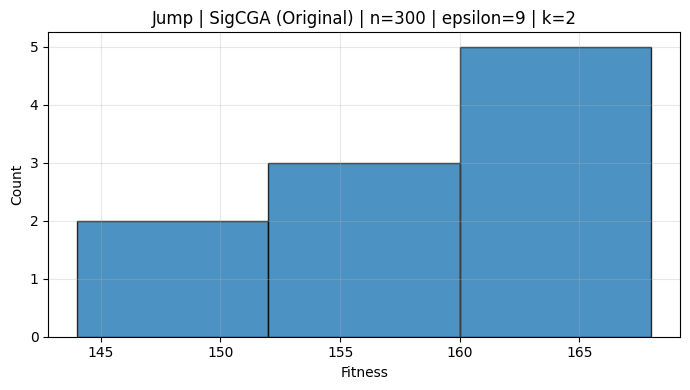

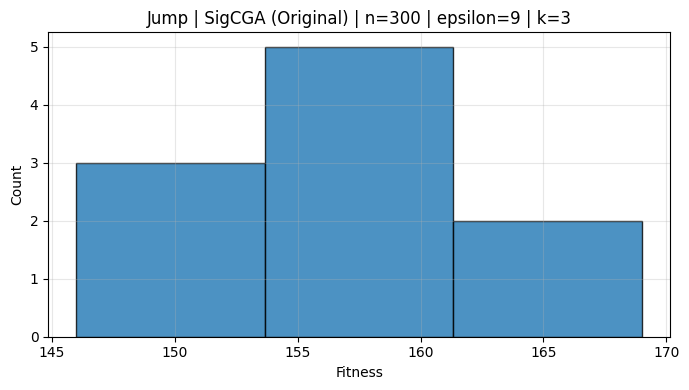

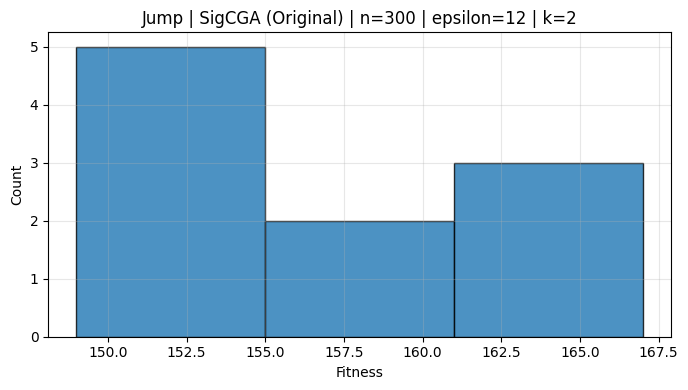

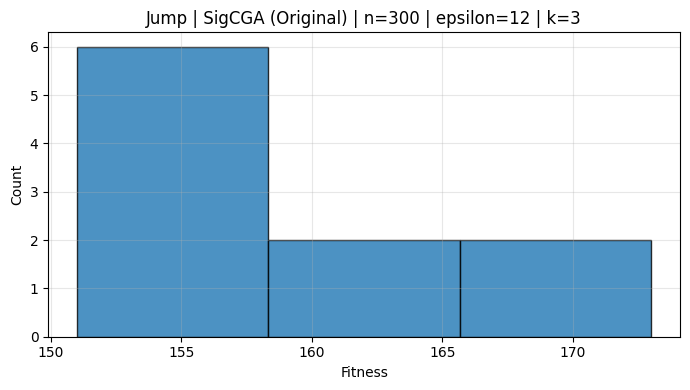

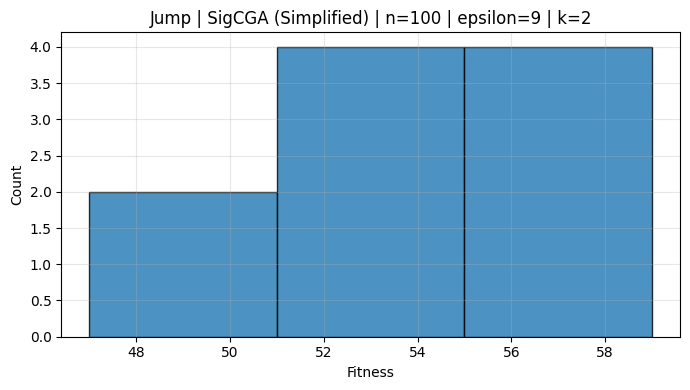

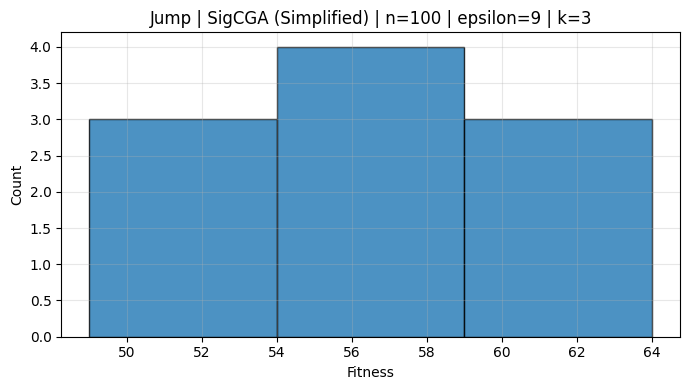

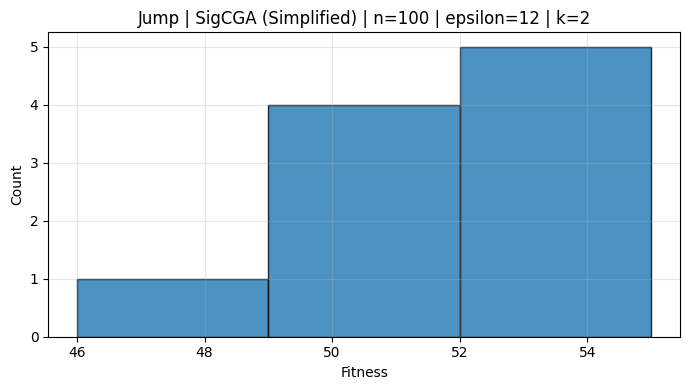

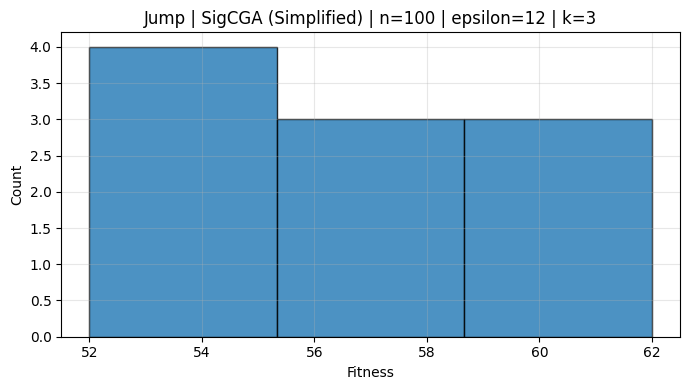

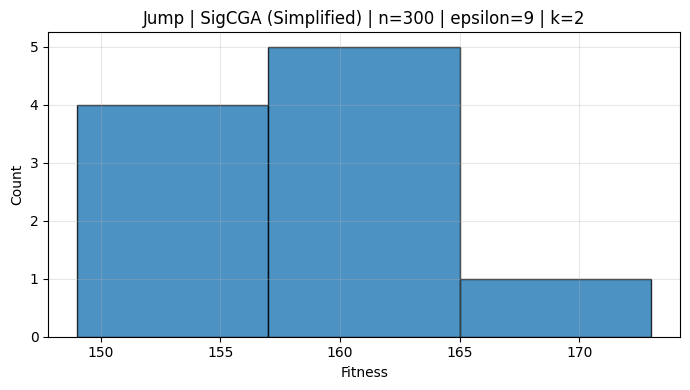

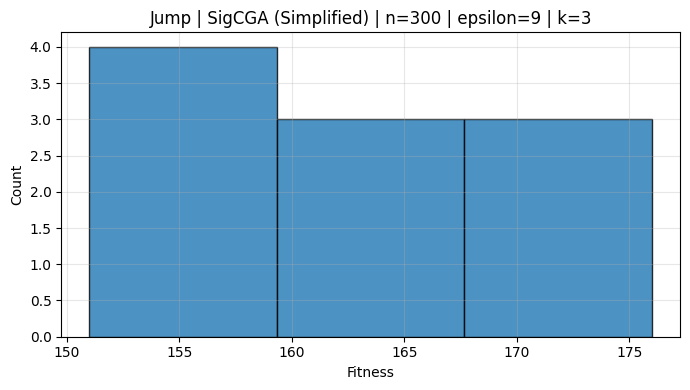

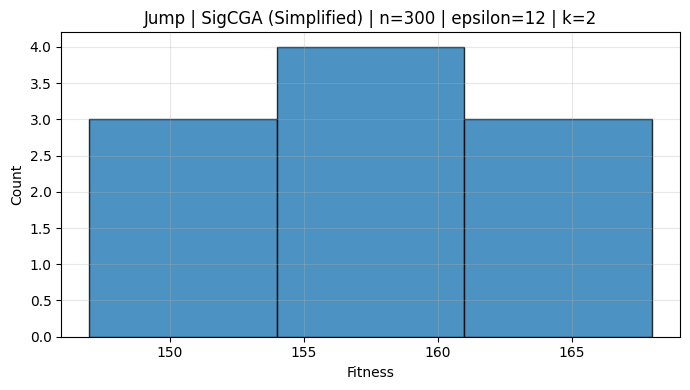

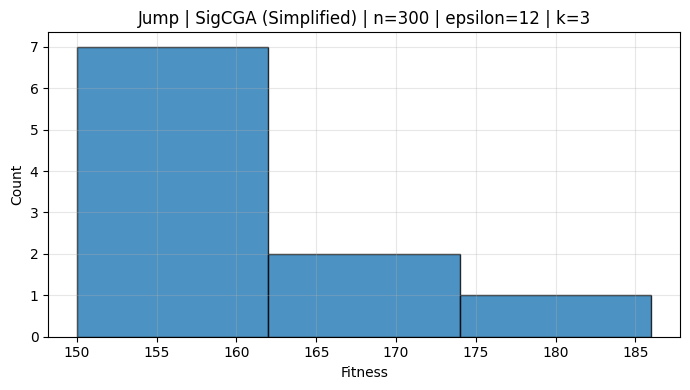

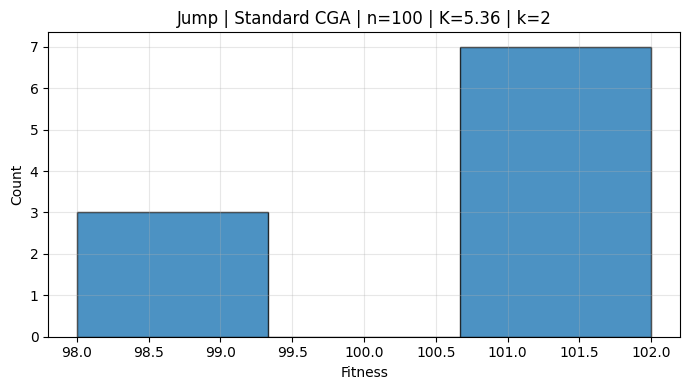

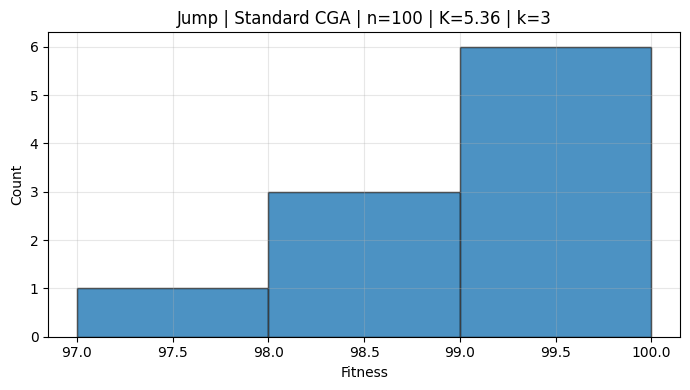

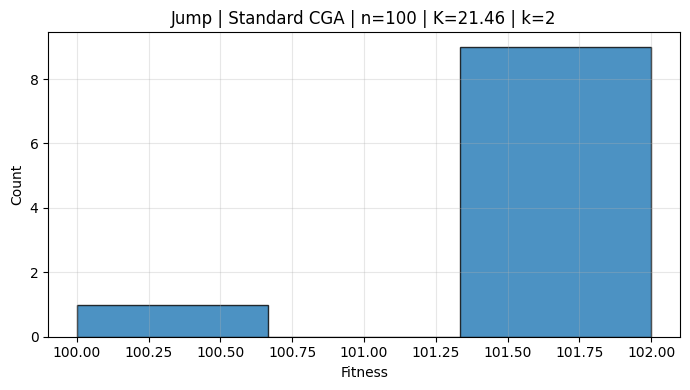

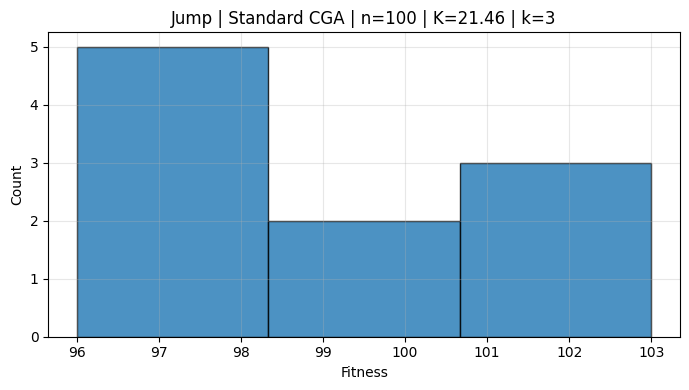

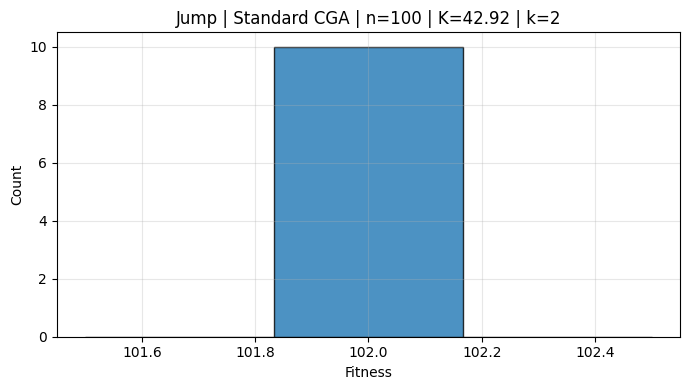

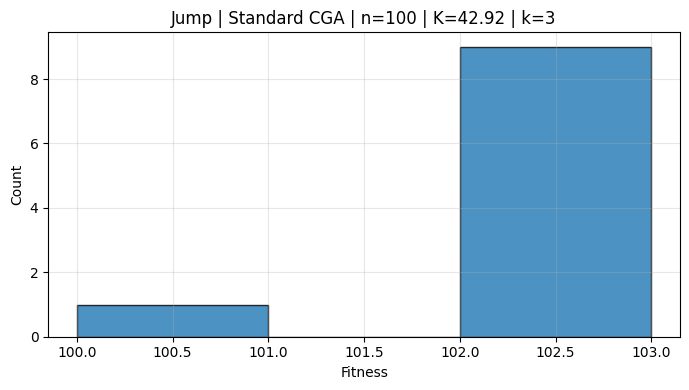

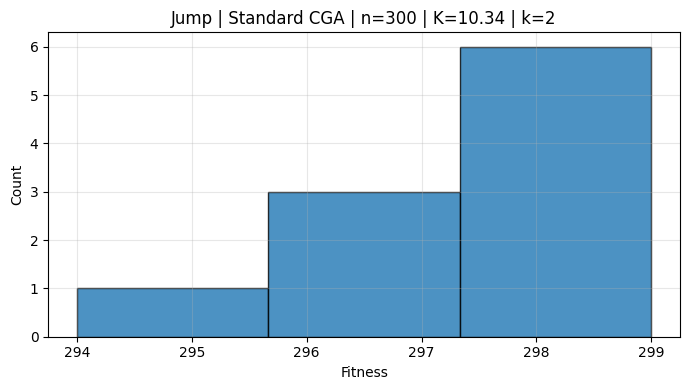

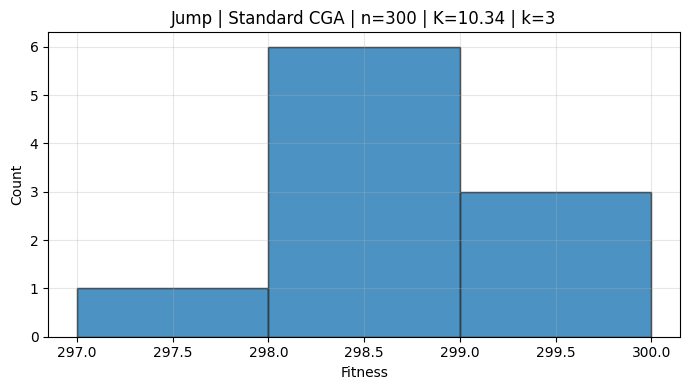

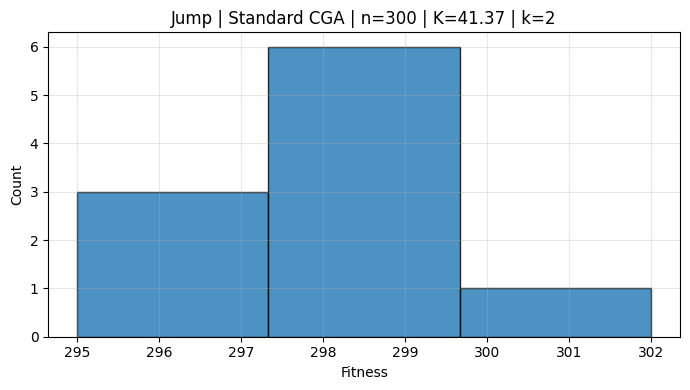

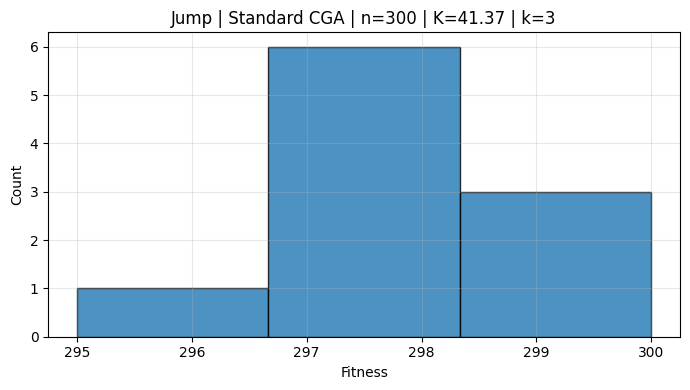

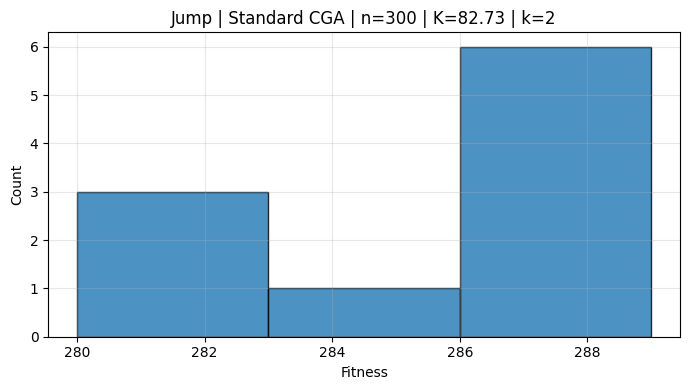

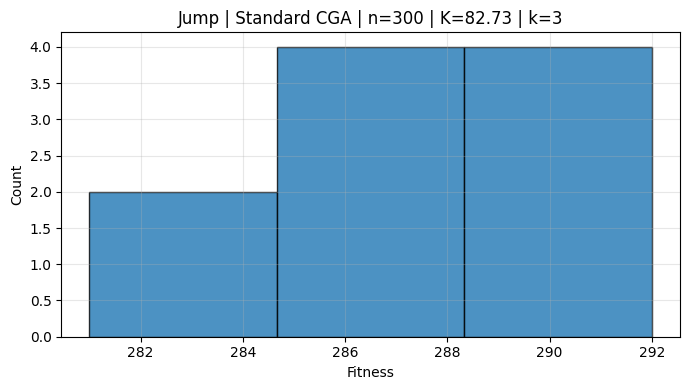

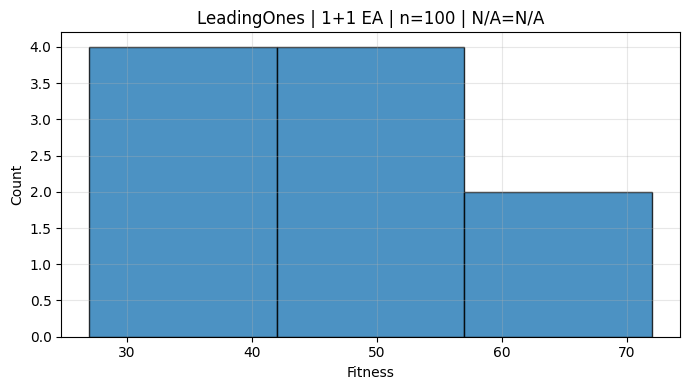

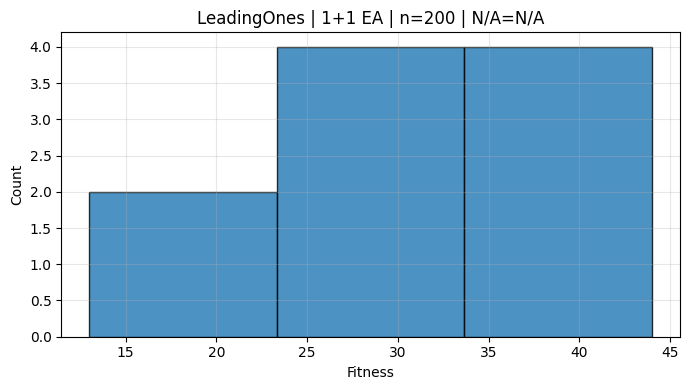

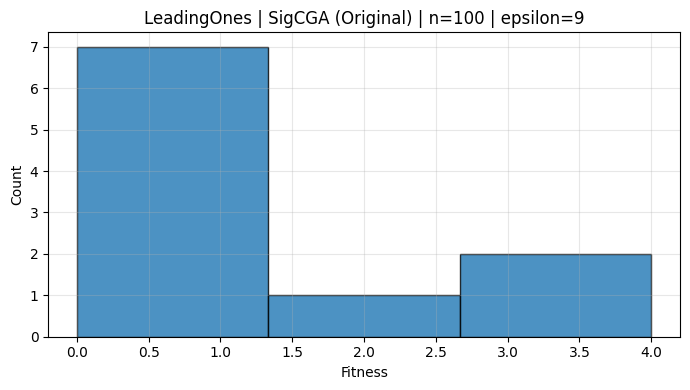

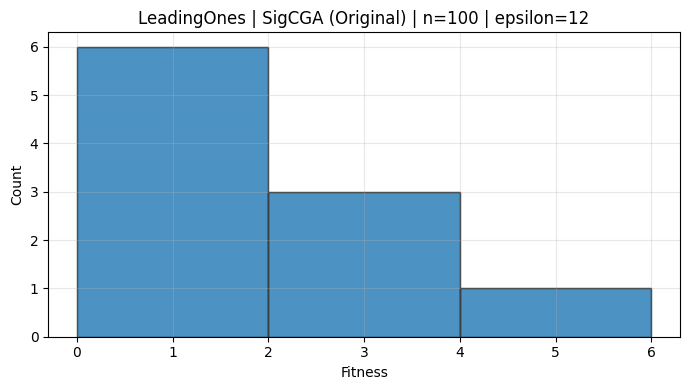

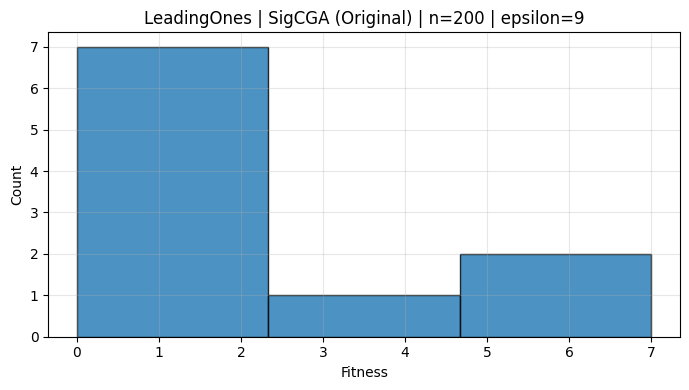

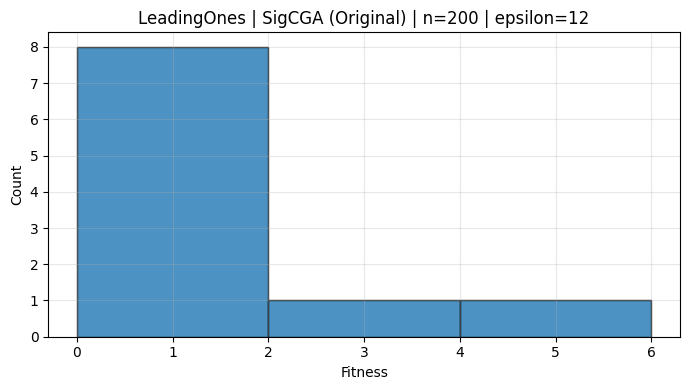

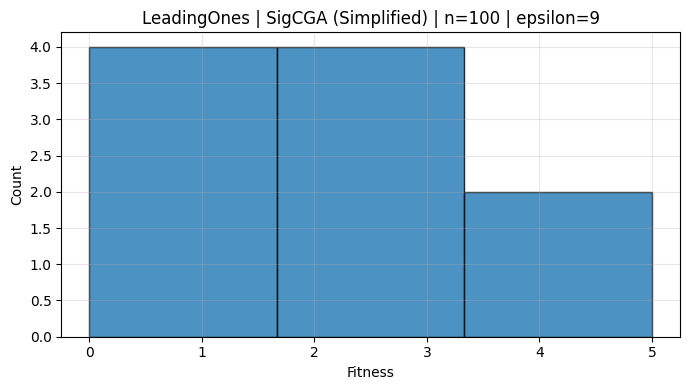

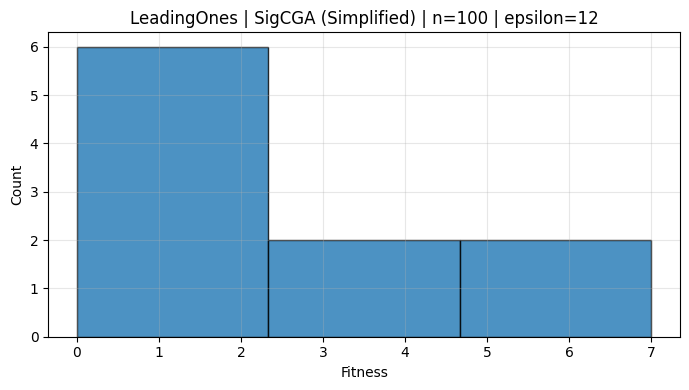

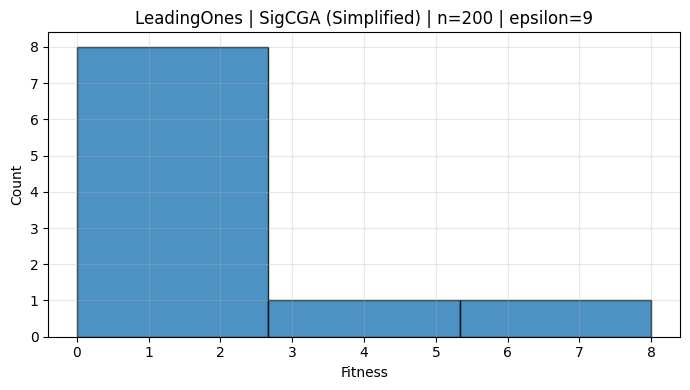

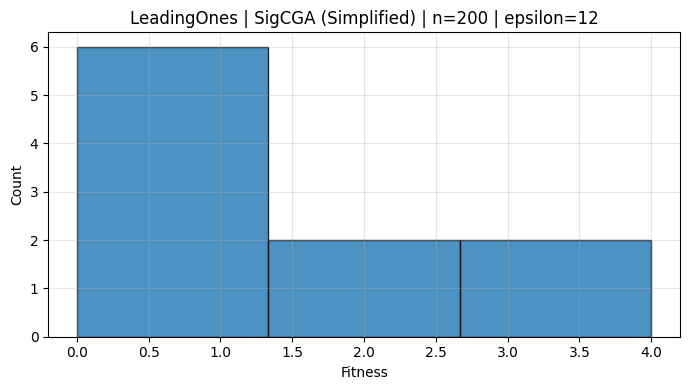

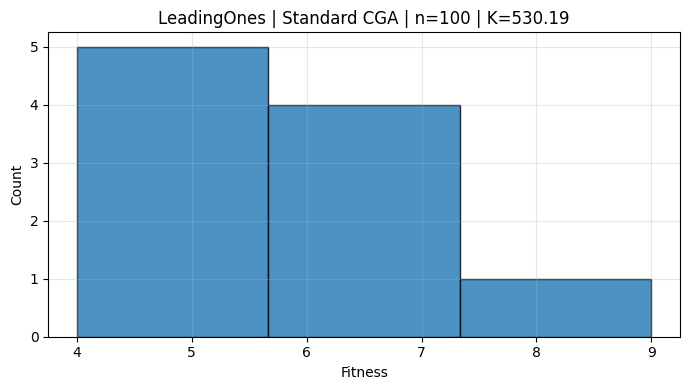

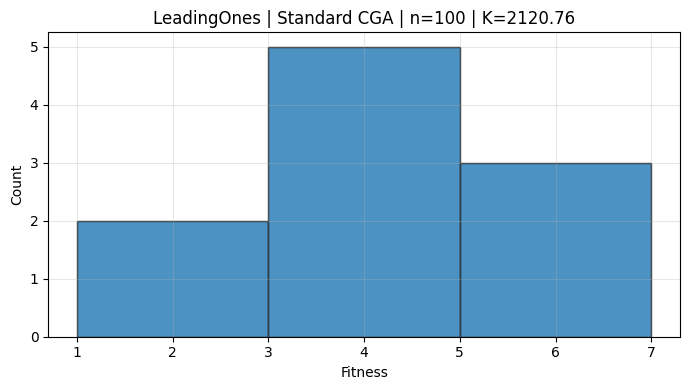

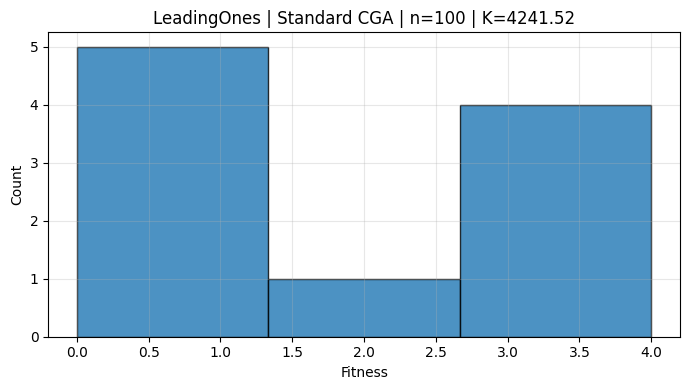

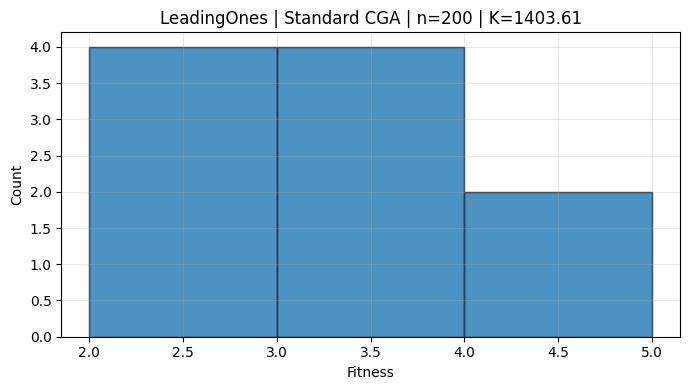

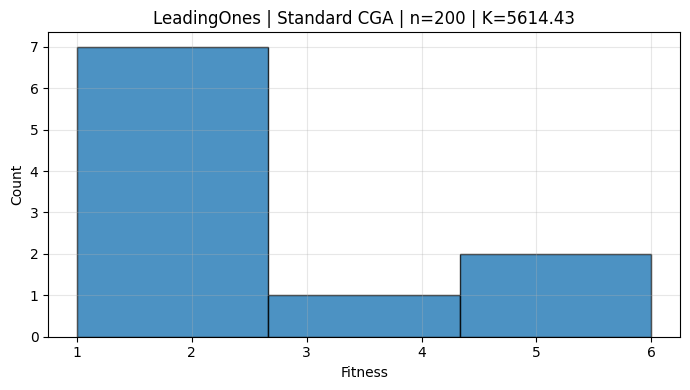

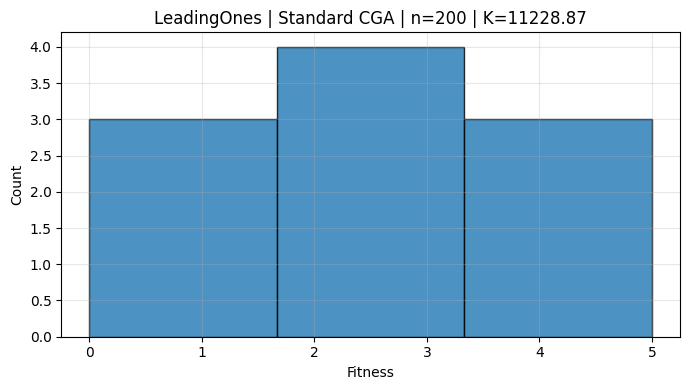

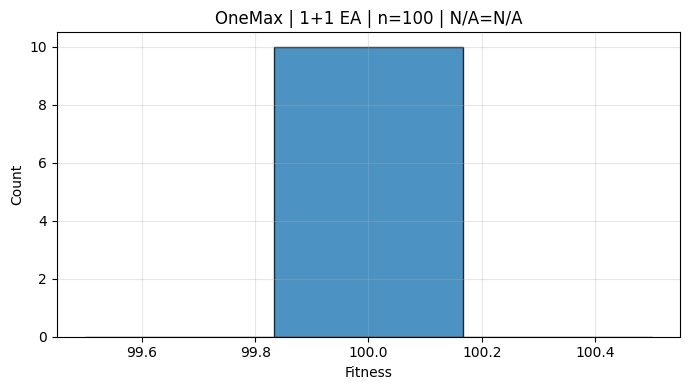

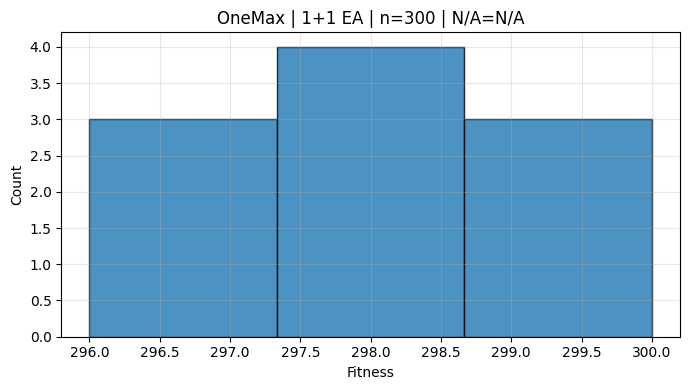

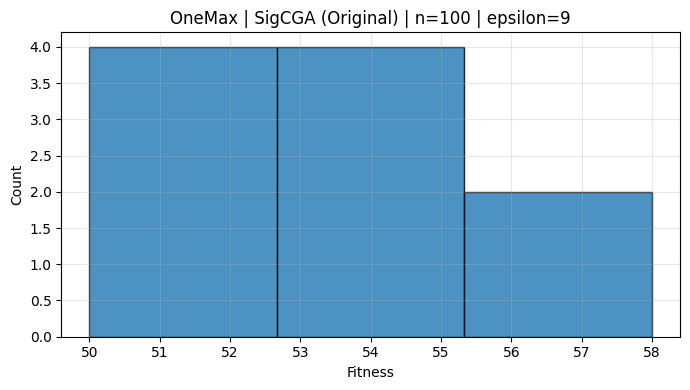

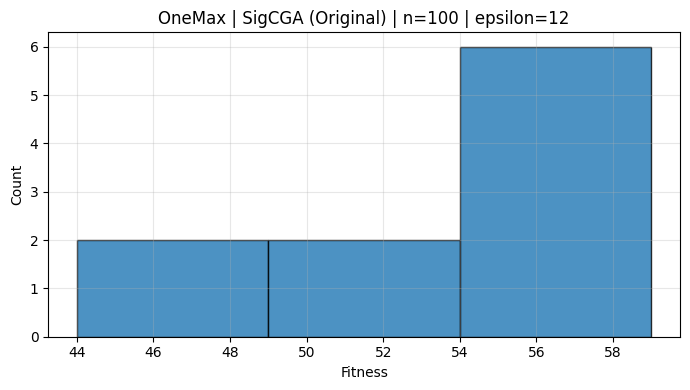

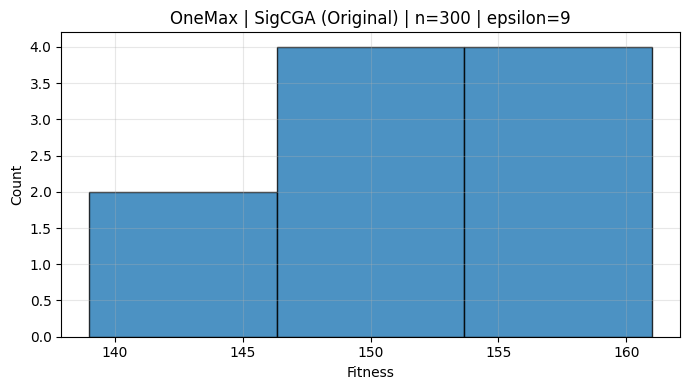

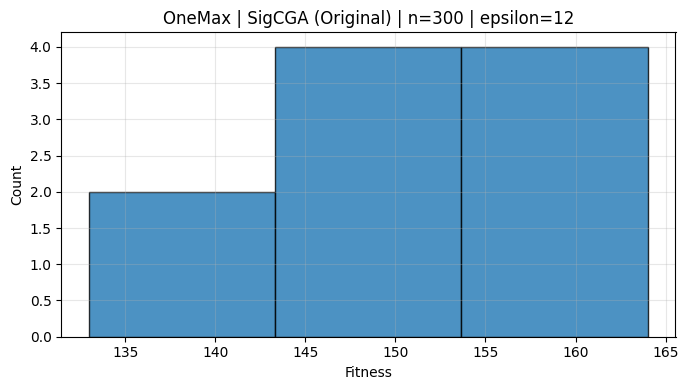

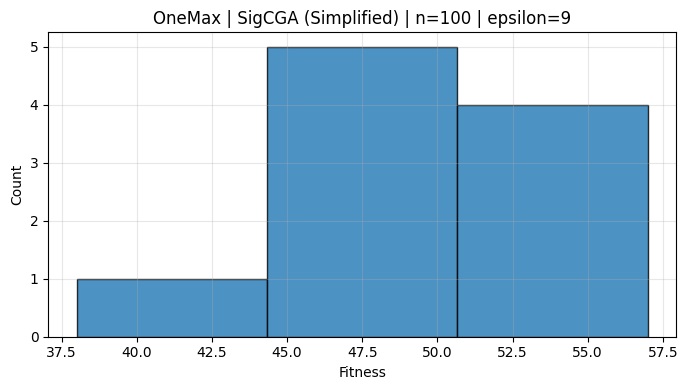

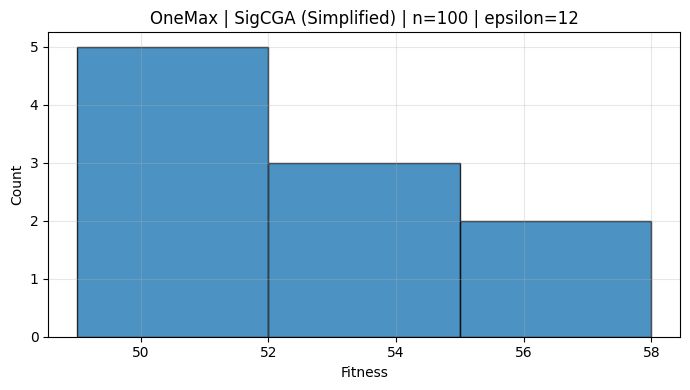

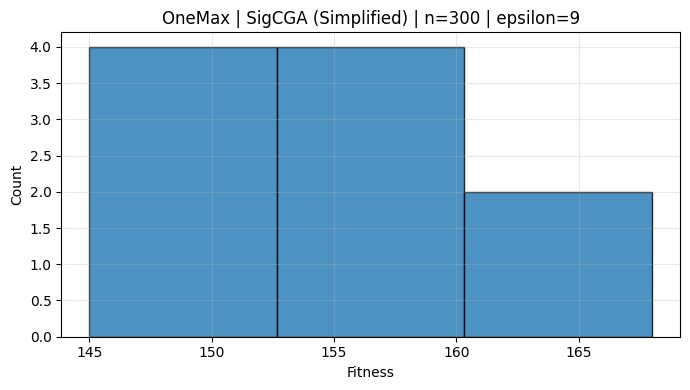

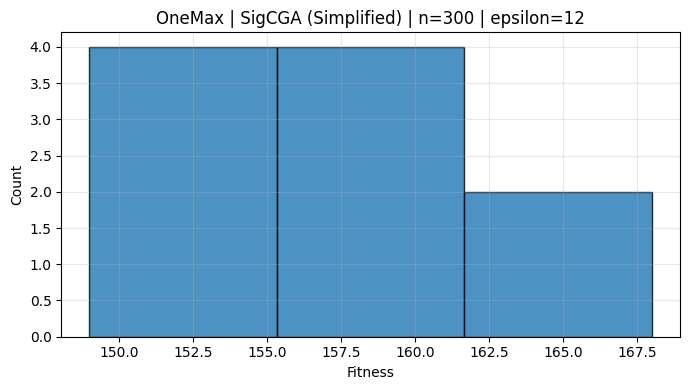

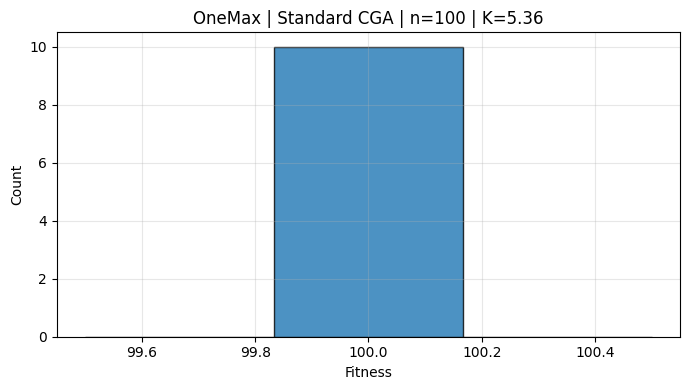

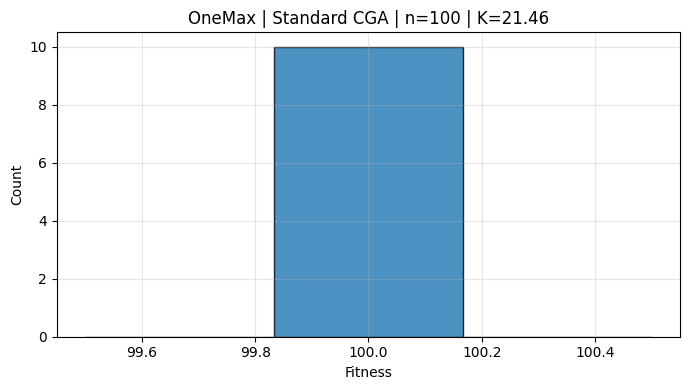

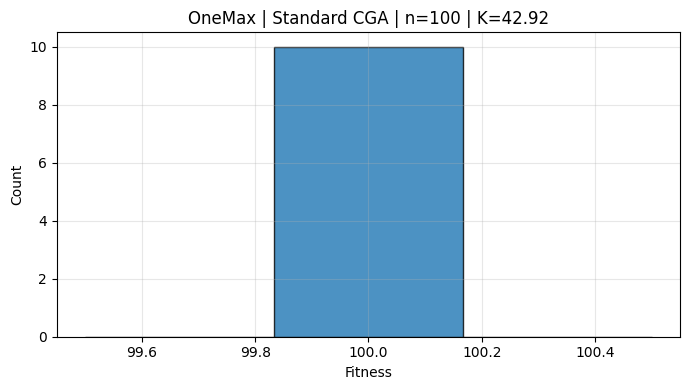

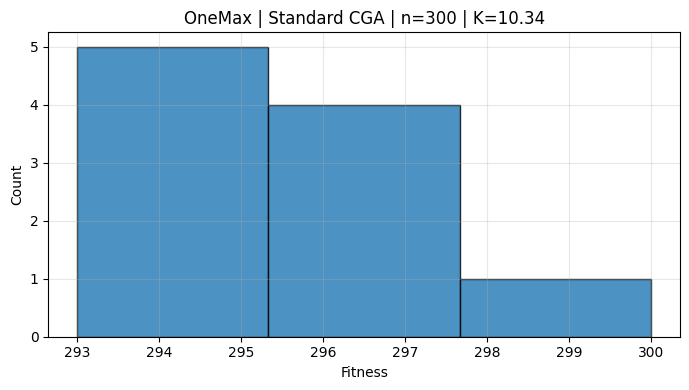

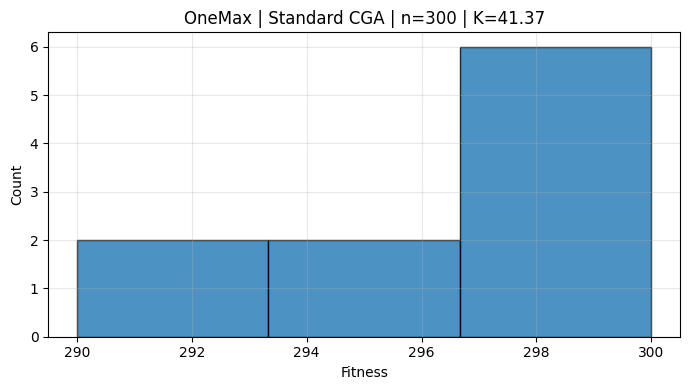

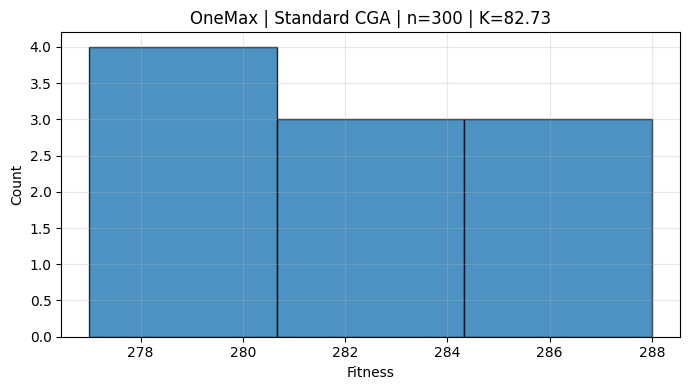

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def compile_all_results():
    result_sources = [
        ("results_sig_cga_simplified_One_Max", "SigCGA (Simplified)", "OneMax", "epsilon"),
        ("results_sig_cga_original_One_Max",   "SigCGA (Original)",   "OneMax", "epsilon"),
        ("results_cga_One_Max",                "Standard CGA",        "OneMax", "K"),
        ("results_one_plus_one_ea_One_Max",    "1+1 EA",              "OneMax", "N/A"),
        ("results_sig_cga_simplified_LeadingOnes", "SigCGA (Simplified)", "LeadingOnes", "epsilon"),
        ("results_sig_cga_original_LeadingOnes",   "SigCGA (Original)",   "LeadingOnes", "epsilon"),
        ("results_cga_LeadingOnes",                "Standard CGA",        "LeadingOnes", "K"),
        ("results_one_plus_one_ea_LeadingOnes",    "1+1 EA",              "LeadingOnes", "N/A"),
        ("results_sig_cga_simplified_Jump", "SigCGA (Simplified)", "Jump", "epsilon"),
        ("results_sig_cga_original_Jump",   "SigCGA (Original)",   "Jump", "epsilon"),
        ("results_cga_Jump",                "Standard CGA",        "Jump", "K"),
        ("results_one_plus_one_ea_Jump",    "1+1 EA",              "Jump", "N/A"),
    ]

    all_data = []

    for var_name, algo, func, param_label in result_sources:
        data_dict = globals().get(var_name, {})
        if not data_dict:
            continue

        for key, val in data_dict.items():
            success_rate, mean_runtime, mean_fit, std_fit = val
            n, param_val, jump_k = None, None, None

            if isinstance(key, int):
                n = key
                param_val = "N/A"
                jump_k = "N/A"
            elif isinstance(key, tuple) and len(key) == 2:
                if func == "Jump" and algo == "1+1 EA":
                    n, jump_k = key
                    param_val = "N/A"
                else:
                    n, param_val = key
                    jump_k = "N/A"
            elif isinstance(key, tuple) and len(key) == 3:
                n, param_val, jump_k = key

            if isinstance(param_val, float):
                param_val = round(param_val, 2)

            all_data.append({
                "Algorithm": algo,
                "Function": func,
                "n": n,
                "Parameter Type": param_label,
                "Parameter Value": param_val,
                "Jump k": jump_k,
                "Success Rate": success_rate,
                "Mean Runtime": mean_runtime,
                "Mean Fitness": mean_fit
            })

    if not all_data:
        return pd.DataFrame()

    df = pd.DataFrame(all_data)
    cols = ["Function", "Algorithm", "n", "Parameter Type", "Parameter Value",
            "Jump k", "Success Rate", "Mean Runtime", "Mean Fitness"]
    return df[cols].sort_values(by=["Function", "Algorithm", "n", "Parameter Value"])


def compile_histogram_runs():
    run_sources = ["hist_runs_OneMax", "hist_runs_LeadingOnes", "hist_runs_Jump"]
    all_runs = []
    for src in run_sources:
        all_runs.extend(globals().get(src, []))
    return pd.DataFrame(all_runs)


def plot_histograms(df_runs):
    if df_runs.empty:
        print("No run-level data found. Run Task 6 experiment cells first.")
        return

    group_cols = ["Function", "Algorithm", "n", "Parameter Type", "Parameter Value", "Jump k"]
    grouped = df_runs.groupby(group_cols, dropna=False)

    for (func, algo, n, p_type, p_val, jump_k), g in grouped:
        plt.figure(figsize=(7, 4))
        bins = max(3, min(15, int(np.sqrt(len(g)))))
        plt.hist(g["Fitness"], bins=bins, edgecolor="black", alpha=0.8)

        title = f"{func} | {algo} | n={n} | {p_type}={p_val}"
        if pd.notna(jump_k):
            title += f" | k={int(jump_k)}"

        plt.title(title)
        plt.xlabel("Fitness")
        plt.ylabel("Count")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


df_summary = compile_all_results()

if not df_summary.empty:
    display(Markdown("### Complete Experiment Summary"))
    display(df_summary.style.format({
        "Mean Runtime": "{:.1f}",
        "Mean Fitness": "{:.2f}",
        "Success Rate": "{:.1%}"
    }).hide(axis="index"))
else:
    print("No results found. Please ensure you have run the experiment cells in Task 6.")

# Histogram plots for each algorithm / fitness function / parameter set
hist_df = compile_histogram_runs()
plot_histograms(hist_df)
